<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/LookingBackOnDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install whitebox
!pip install tqdm
!pip install tqdm_joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
df_soybeans = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet")
df_soybeans.info()

df_corn = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years_with_divided_precipitation.parquet")
df_corn.info()


df_wheat = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years_with_divided_precipitation.parquet")
df_wheat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611315 entries, 0 to 55531
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       611315 non-null  float64
 1   y                       611315 non-null  float64
 2   yield                   611315 non-null  float64
 3   field                   611315 non-null  object 
 4   year                    611315 non-null  int64  
 5   ndvi_mean               611315 non-null  float64
 6   ndvi_max                611315 non-null  float64
 7   ndvi_range              611315 non-null  float64
 8   lst_median_k            611315 non-null  float64
 9   lst_range_k             611315 non-null  float64
 10  lst_max_k               611315 non-null  float64
 11  pr_season_mm            611315 non-null  float64
 12  pr_mean_mm_day          611315 non-null  float64
 13  pr_max_mm_day           611315 non-null  float64
 14  pr_range_mm_day         61

In [ ]:
df_soybeans_CF_271 = df_soybeans[df_soybeans["field"] == "Central Farm_2-71"]
df_soybeans_CF_271.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36595 entries, 7714 to 30847
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  36595 non-null  float64
 1   y                  36595 non-null  float64
 2   yield              36595 non-null  float64
 3   field              36595 non-null  object 
 4   year               36595 non-null  int64  
 5   elevation          36595 non-null  float32
 6   slope              36595 non-null  float32
 7   aspect             36595 non-null  float32
 8   ndvi_mean          36595 non-null  float64
 9   ndvi_max           36595 non-null  float64
 10  ndvi_range         36595 non-null  float64
 11  lst_median_k       36595 non-null  float64
 12  lst_range_k        36595 non-null  float64
 13  lst_max_k          36595 non-null  float64
 14  pr_season_mm       36595 non-null  float64
 15  pr_mean_mm_day     36595 non-null  float64
 16  pr_max_mm_day      36595

### Filtering the extreme datapoints


In [ ]:
df_wheat_filtered = df_wheat[(df_wheat["yield"] < df_wheat["yield"].quantile(0.98)) & (df_wheat["yield"] > df_wheat["yield"].quantile(0.02))]
df_soybeans_filtered = df_soybeans[(df_soybeans["yield"] < df_soybeans["yield"].quantile(0.98)) & (df_soybeans["yield"] > df_soybeans["yield"].quantile(0.02))]
df_corn_filtered = df_corn[(df_wheat["yield"] < df_corn["yield"].quantile(0.98)) & (df_corn["yield"] > df_corn["yield"].quantile(0.02))]

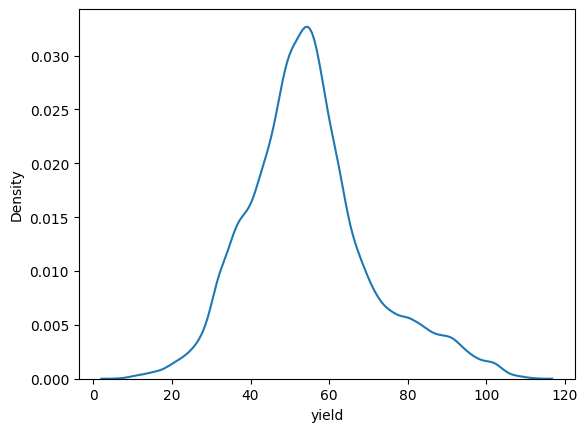

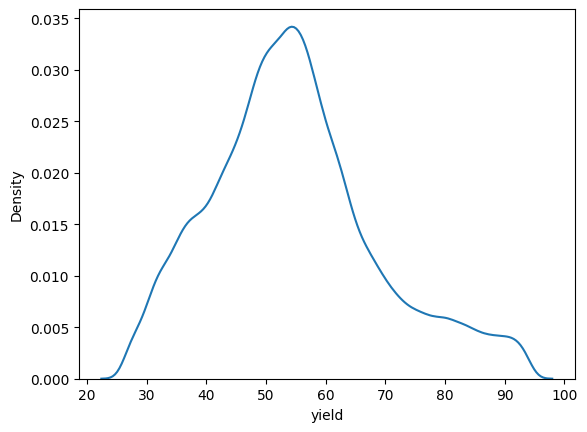

In [ ]:
sns.kdeplot(data=df_wheat['yield'])
plt.show()

sns.kdeplot(data=df_wheat_filtered['yield'])
plt.show()

In [ ]:
print(df_soybeans.info())
print(df_wheat.info())
print(df_corn.info())

df_soybeans = df_soybeans_filtered
df_corn = df_corn_filtered
df_wheat = df_wheat_filtered

print("===========================")
print(df_soybeans.info())
print(df_wheat.info())
print(df_corn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 586861 entries, 0 to 55520
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       586861 non-null  float64
 1   y                       586861 non-null  float64
 2   yield                   586861 non-null  float64
 3   field                   586861 non-null  object 
 4   year                    586861 non-null  int64  
 5   ndvi_mean               586861 non-null  float64
 6   ndvi_max                586861 non-null  float64
 7   ndvi_range              586861 non-null  float64
 8   lst_median_k            586861 non-null  float64
 9   lst_range_k             586861 non-null  float64
 10  lst_max_k               586861 non-null  float64
 11  pr_season_mm            586861 non-null  float64
 12  pr_mean_mm_day          586861 non-null  float64
 13  pr_max_mm_day           586861 non-null  float64
 14  pr_range_mm_day         58

### Normal Scaling the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling the variables that need scaling

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr"
]


# Copy full dataset
df_soybeans_scaled = df_soybeans.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_soybeans_scaled[need_std] = scaler.fit_transform(df_soybeans_scaled[need_std])


# Copy full dataset
df_wheat_scaled = df_wheat.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_wheat_scaled[need_std] = scaler.fit_transform(df_wheat_scaled[need_std])



# Copy full dataset
df_corn_scaled = df_corn.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_corn_scaled[need_std] = scaler.fit_transform(df_corn_scaled[need_std])


### let's filter out the extreme values in vegetation indices

2022 seems to have bad values for gi


In [ ]:
df_corn_scaled['gi_max'].quantile(0.99)
sns.scatterplot(data=df_corn_scaled[df_corn_scaled['gi_max'] < df_corn_scaled['gi_max'].quantile(0.99)], x= 'gi_max', y='yield')

df_corn_scaled = df_corn_scaled[df_corn_scaled['gi_max'] < df_corn_scaled['gi_max'].quantile(0.99)]

In [ ]:
df_corn_scaled['gi_max'].quantile(0.8)

np.float64(10.119333599025618)

In [ ]:
import pandas as pd

df = df_soybeans.copy()

# 1) Field-level std
df["field_yield_std"] = df.groupby("field")["yield"].transform("std")

# 2) Point-level std across years
df["point_yield_std"] = df.groupby(["field","x","y"])["yield"].transform("std")

# (Optional) count number of years per point
df["point_n_years"] = df.groupby(["field","x","y"])["year"].transform("nunique")

# 3) Stable mask
stable_mask = (df["point_n_years"] >= 2) & (df["point_yield_std"] < df["field_yield_std"])

# 4) Filter, but preserve ALL columns
df_soybeans_stable = df.loc[stable_mask].reset_index(drop=True)

# Inspect
print(df_soybeans_stable.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295404 entries, 0 to 295403
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  295404 non-null  float64
 1   y                  295404 non-null  float64
 2   yield              295404 non-null  float64
 3   field              295404 non-null  object 
 4   year               295404 non-null  int64  
 5   elevation          295404 non-null  float32
 6   slope              295404 non-null  float32
 7   aspect             295404 non-null  float32
 8   ndvi_mean          295404 non-null  float64
 9   ndvi_max           295404 non-null  float64
 10  ndvi_range         295404 non-null  float64
 11  lst_median_k       295404 non-null  float64
 12  lst_range_k        295404 non-null  float64
 13  lst_max_k          295404 non-null  float64
 14  pr_season_mm       295404 non-null  float64
 15  pr_mean_mm_day     295404 non-null  float64
 16  pr

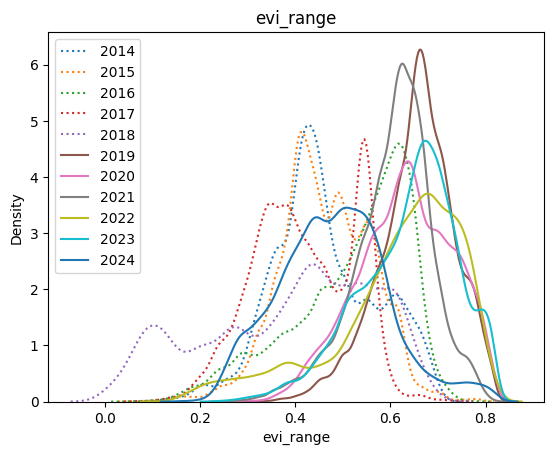

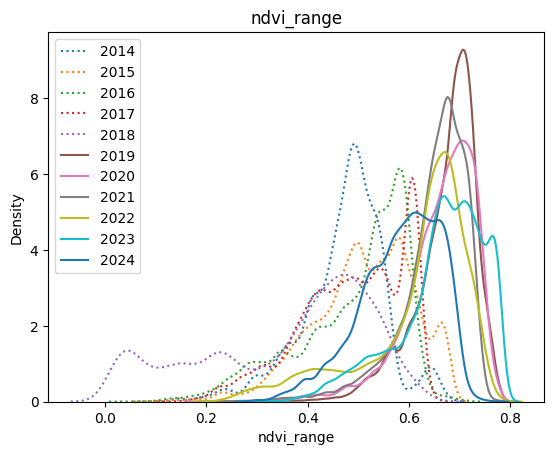

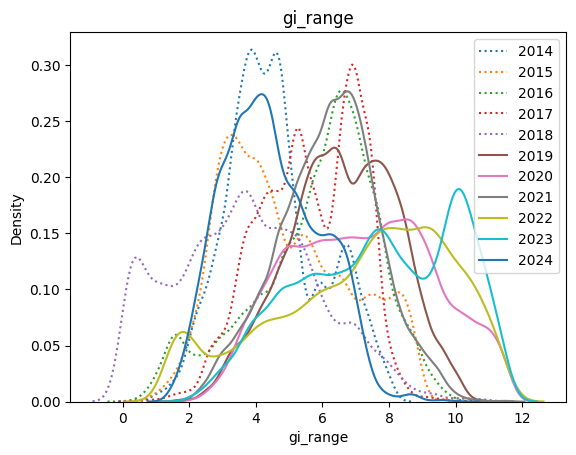

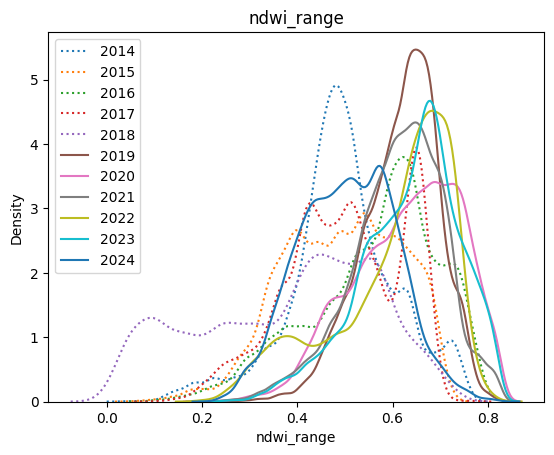

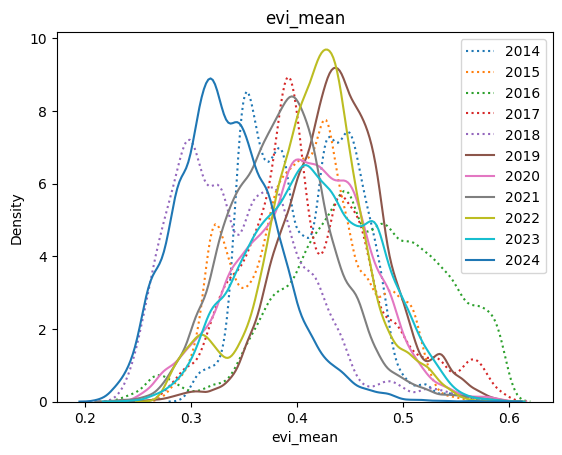

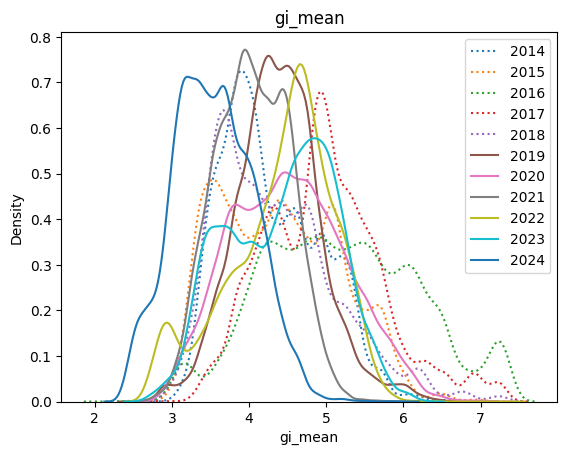

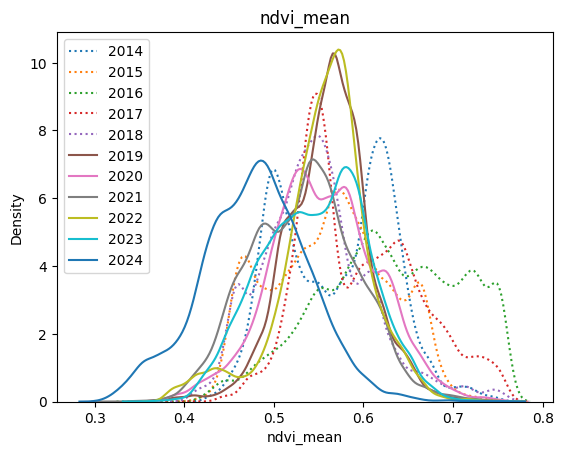

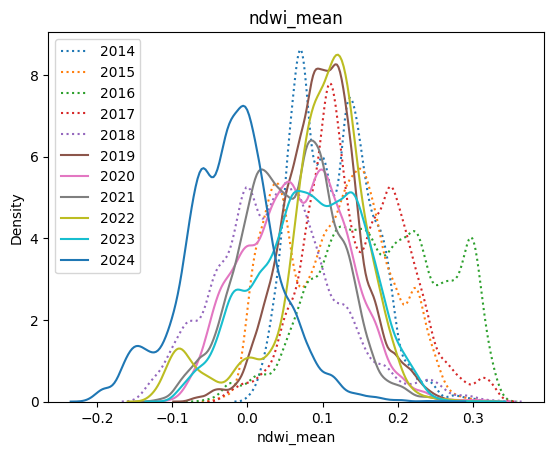

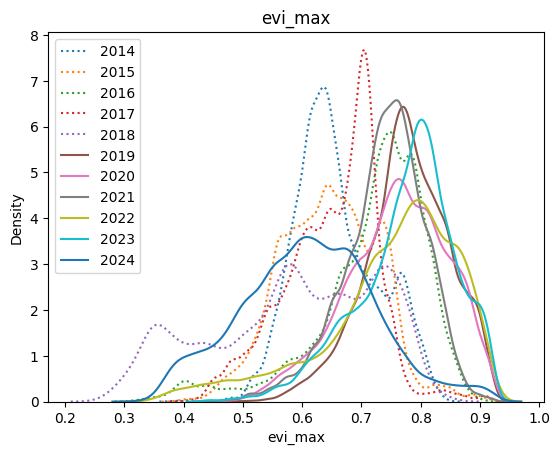

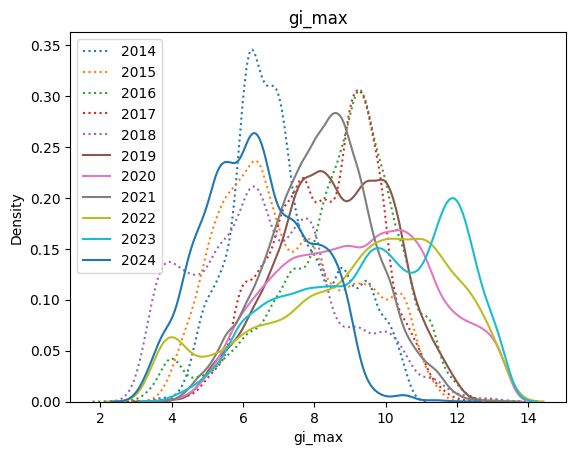

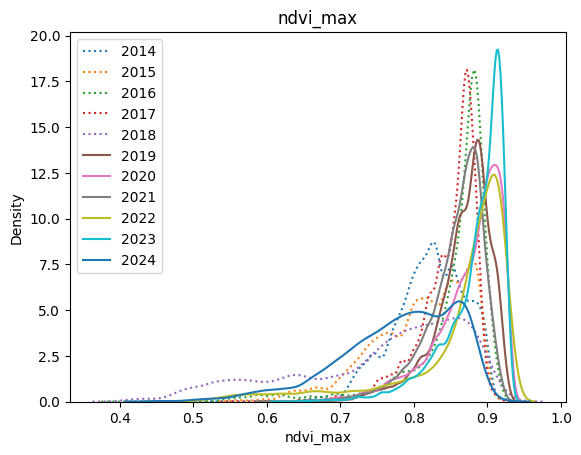

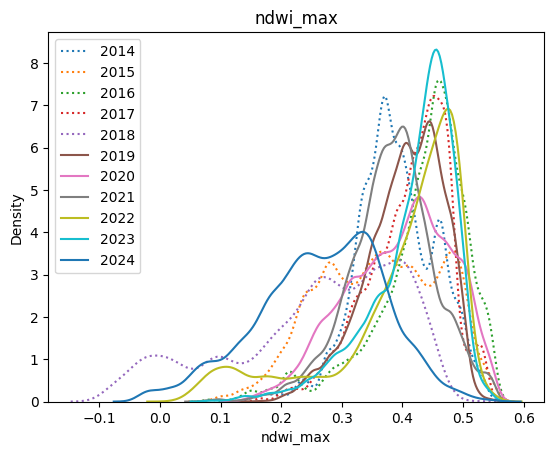

In [ ]:
df_ = df_corn_scaled.copy()
for interested_col in ["evi_range", "ndvi_range", "gi_range", "ndwi_range", "evi_mean", "gi_mean", "ndvi_mean", "ndwi_mean", "evi_max", "gi_max", "ndvi_max", "ndwi_max"]:
  for year in range(2014,2019):
    sns.kdeplot(df_[(df_['year'] == year) & (df_[interested_col] < df_[interested_col].quantile(0.99))][interested_col], linestyle=':')
  for year in range(2019,2025):
    sns.kdeplot(df_[(df_['year'] == year) & (df_[interested_col] < df_[interested_col].quantile(0.99))][interested_col])
  plt.title(interested_col)
  plt.legend(range(2014,2025))
  plt.show()



### let's look at the individual feature's effect on yield

In [ ]:
df_wheat_scaled.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
       'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
       'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
       'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
       'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect',
       'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity',
       'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day',
       'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day',
       'spring_pr_mean_mm_day', 'spring_pr_range_mm_day',
       'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day',
       'summer_pr_mean_mm_day', 'summer_pr_range_mm_day',



### Correlation between yield and the different precipitation phases



In [37]:
df_wheat_scaled.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
       'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
       'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
       'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
       'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect',
       'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity',
       'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day',
       'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day',
       'spring_pr_mean_mm_day', 'spring_pr_range_mm_day',
       'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day',
       'summer_pr_mean_mm_day', 'summer_pr_range_mm_day',


In [46]:
import numpy as np
import pandas as pd

df_yield = df_soybeans_scaled.copy()

features = [
    'fall_aridity','fall_pr_max_mm_day','fall_pr_mean_mm_day','fall_pr_range_mm_day','fall_pr_season_mm',
    'spring_aridity','spring_pr_max_mm_day','spring_pr_mean_mm_day','spring_pr_range_mm_day','spring_pr_season_mm',
    'summer_aridity','summer_pr_max_mm_day','summer_pr_mean_mm_day','summer_pr_range_mm_day','summer_pr_season_mm',
    #  'winter_aridity', 'winter_pr_max_mm_day', 'winter_pr_mean_mm_day', 'winter_pr_range_mm_day','winter_pr_season_mm'
]

rows = []
for col in features:
    print("=================================================================")
    print(f"Correlation: Yield X {col}")
    # ensure numeric + drop NA pairwise
    s_y = pd.to_numeric(df_yield['yield'], errors='coerce')
    s_x = pd.to_numeric(df_yield[col],      errors='coerce')
    corr = s_y.corr(s_x)  # Pearson by default
    print(corr)
    rows.append({"feature": col, "correlation": corr})
    print("=================================================================\n")

correlation_metrics = pd.DataFrame(rows).sort_values('correlation', ascending=False).reset_index(drop=True)
print(correlation_metrics.info())
print(correlation_metrics)


Correlation: Yield X fall_aridity
0.1282416673024307

Correlation: Yield X fall_pr_max_mm_day
0.1565782364931848

Correlation: Yield X fall_pr_mean_mm_day
0.15250407788397377

Correlation: Yield X fall_pr_range_mm_day
0.1565782364931848

Correlation: Yield X fall_pr_season_mm
0.15250408206891003

Correlation: Yield X spring_aridity
0.16504819641731092

Correlation: Yield X spring_pr_max_mm_day
0.14361168600743562

Correlation: Yield X spring_pr_mean_mm_day
0.11772317236808319

Correlation: Yield X spring_pr_range_mm_day
0.14361168600743562

Correlation: Yield X spring_pr_season_mm
0.1177231815881385

Correlation: Yield X summer_aridity
0.1874309531152581

Correlation: Yield X summer_pr_max_mm_day
0.05802644309989889

Correlation: Yield X summer_pr_mean_mm_day
0.2024466555848484

Correlation: Yield X summer_pr_range_mm_day
0.05802644309989889

Correlation: Yield X summer_pr_season_mm
0.20244666100511013

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns 

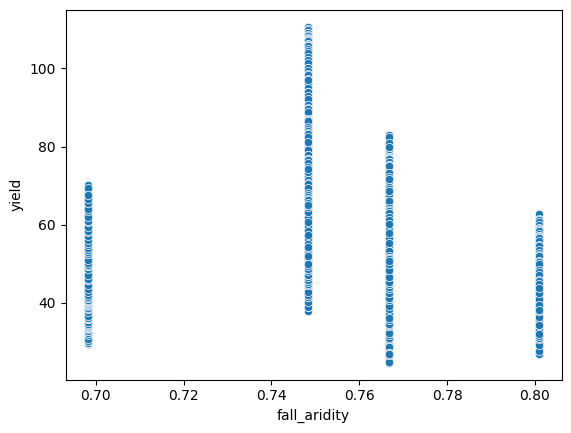

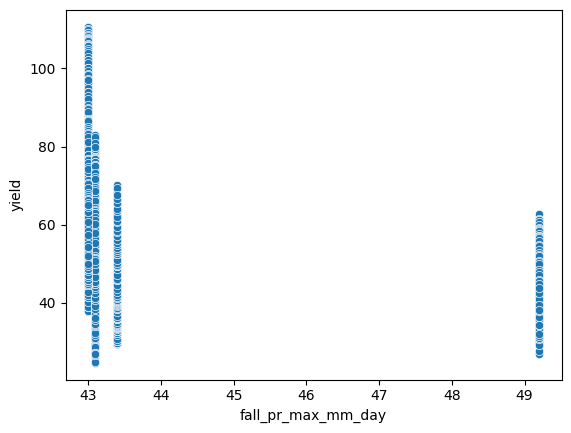

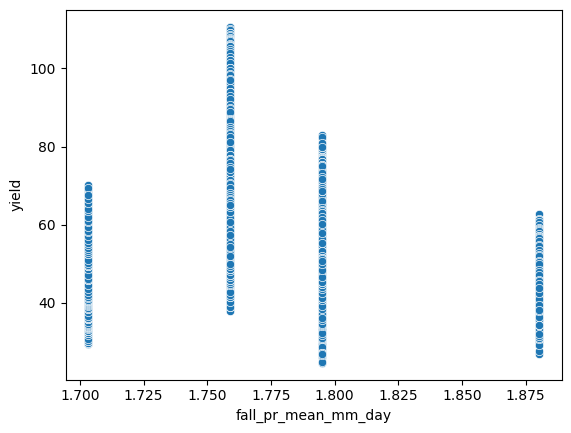

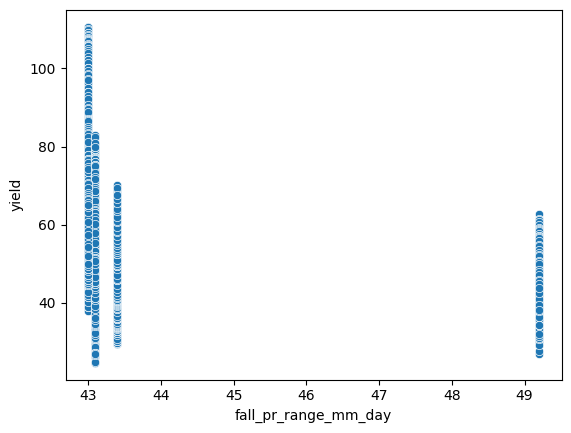

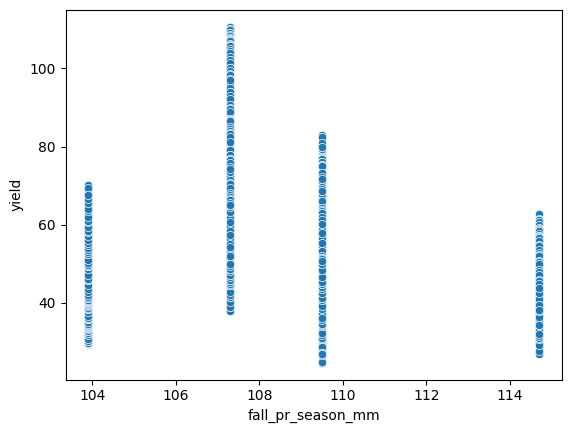

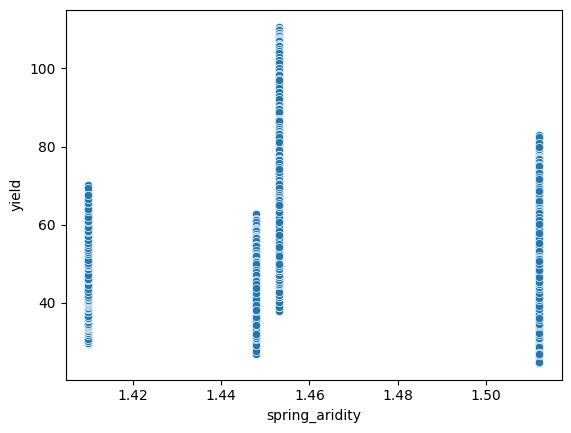

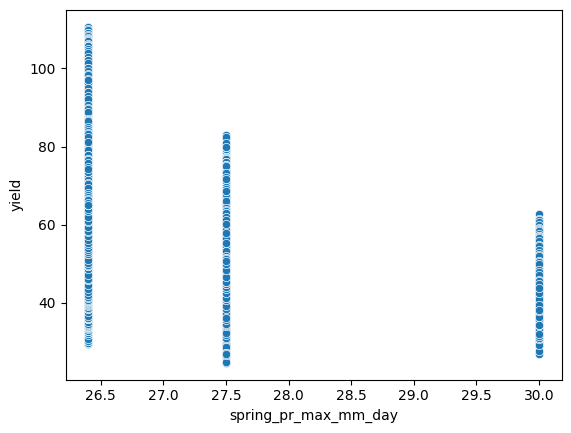

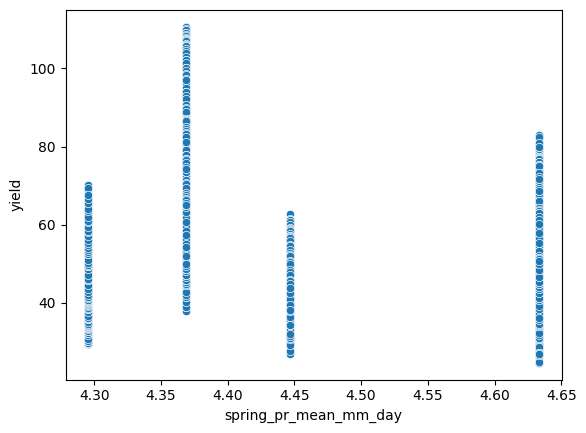

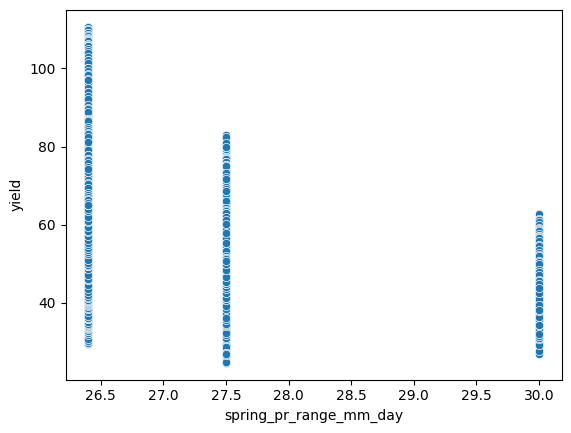

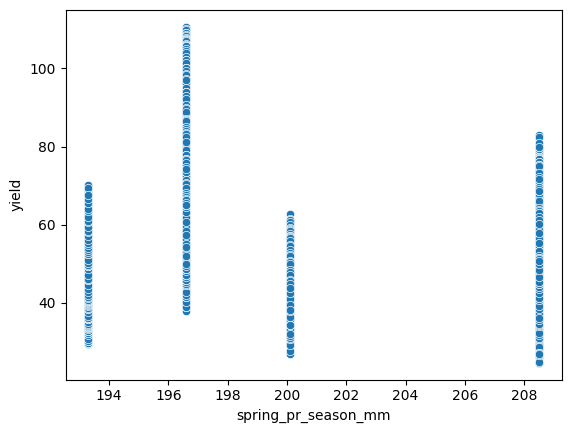

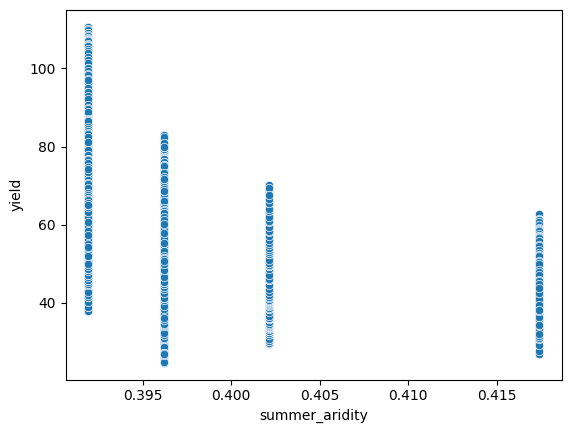

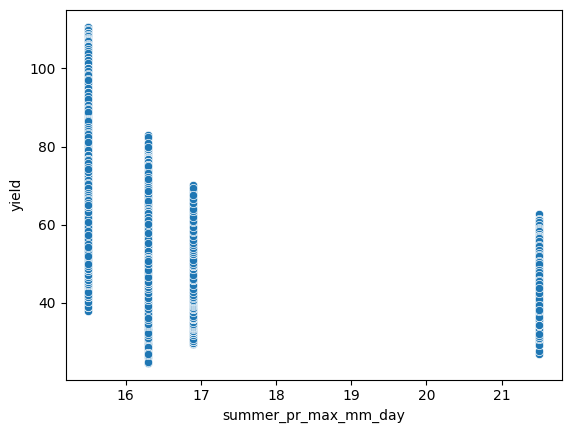

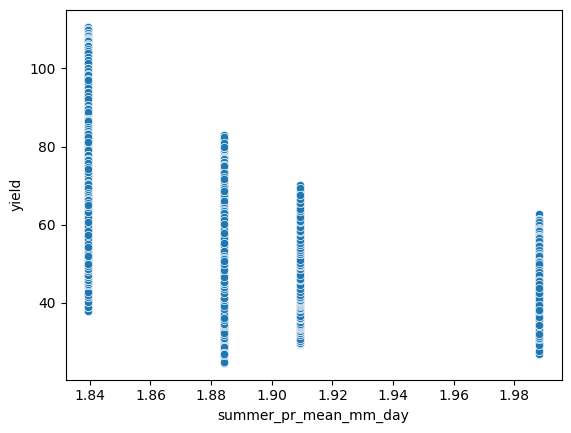

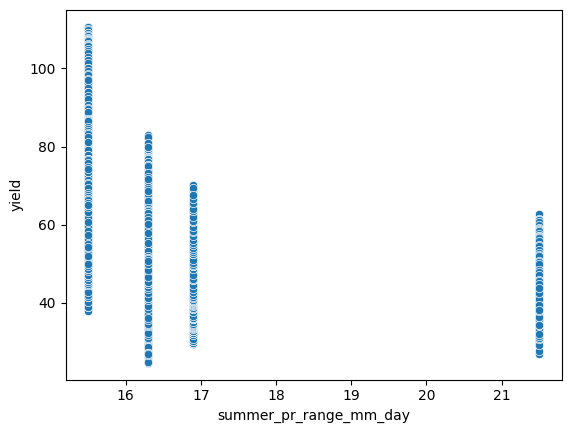

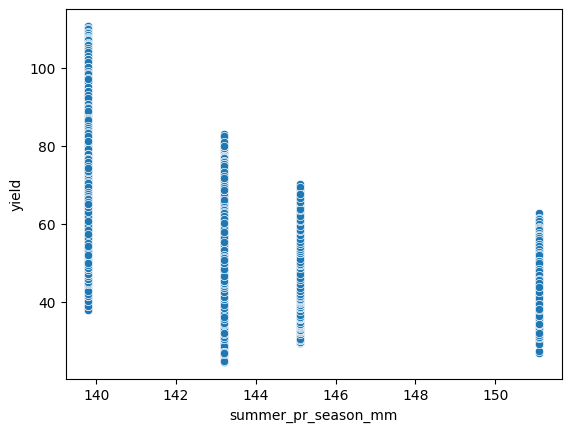

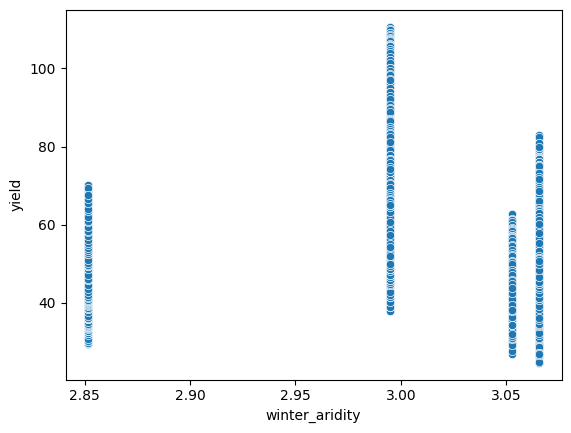

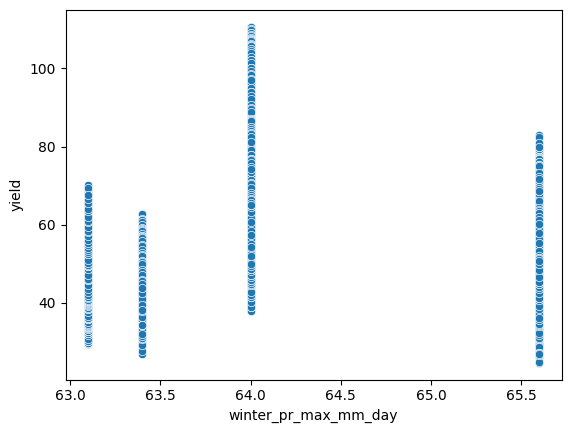

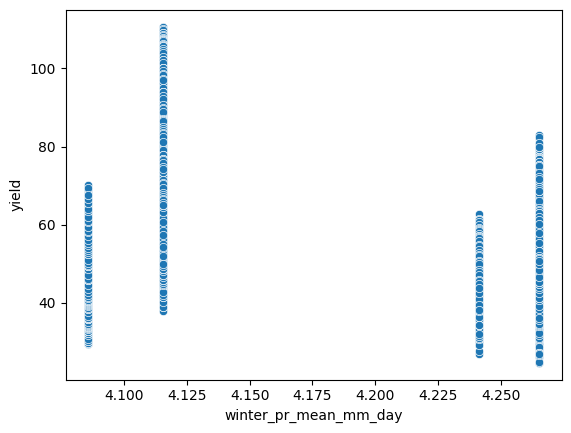

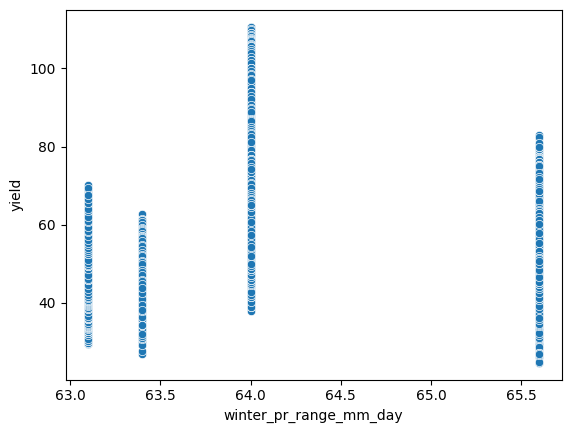

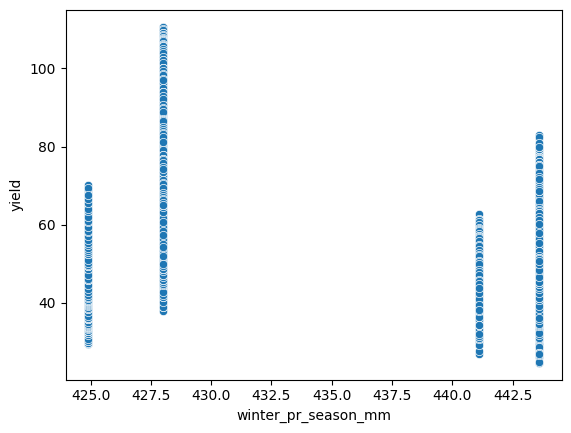

In [ ]:
df_ = df_wheat_scaled[df_wheat_scaled['year'] == 2023]

for interested_col in [ 'fall_aridity',
       'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day',
       'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day',
       'spring_pr_mean_mm_day', 'spring_pr_range_mm_day',
       'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day',
       'summer_pr_mean_mm_day', 'summer_pr_range_mm_day',
       'summer_pr_season_mm', 'winter_aridity', 'winter_pr_max_mm_day',
       'winter_pr_mean_mm_day', 'winter_pr_range_mm_day',
       'winter_pr_season_mm']:
       sns.scatterplot(data=df_, x=interested_col, y='yield')
       plt.show()

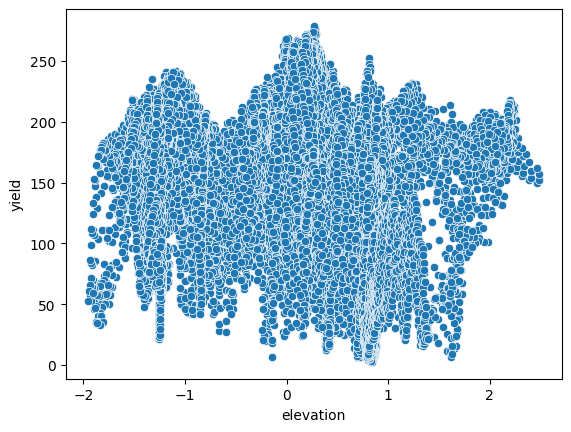

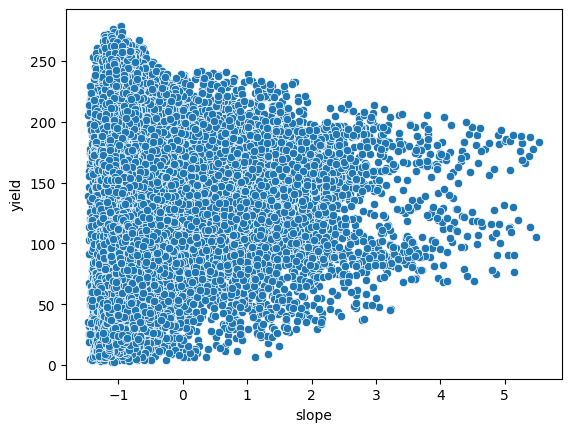

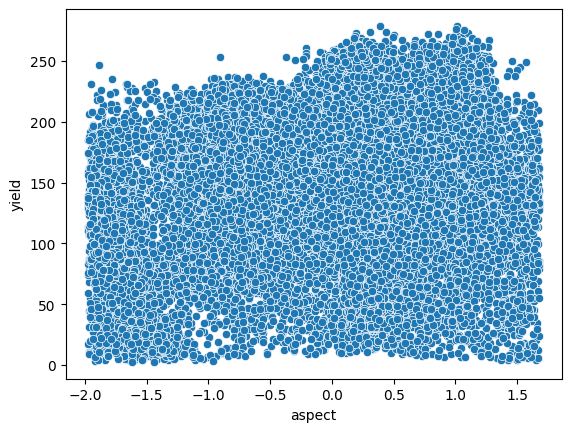

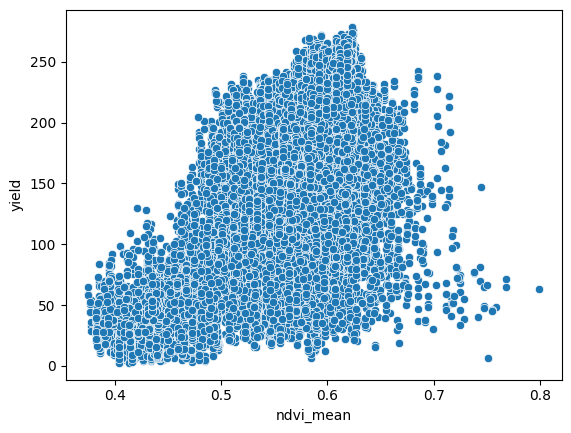

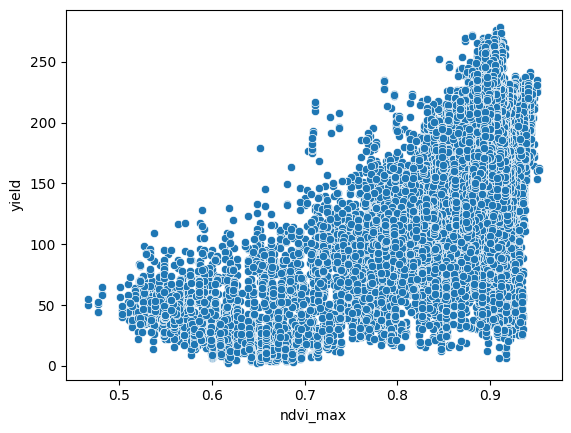

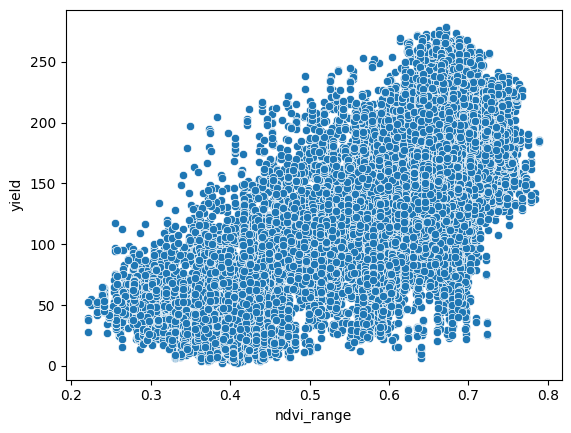

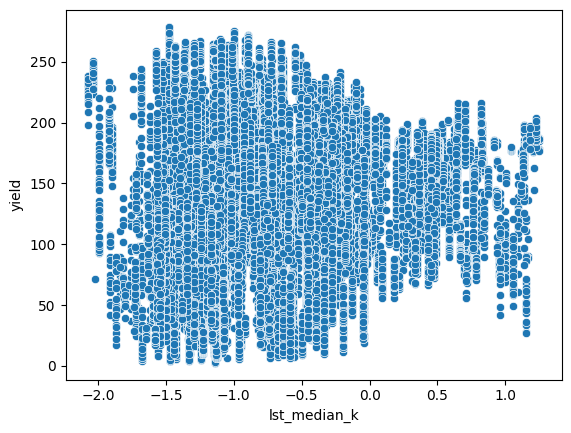

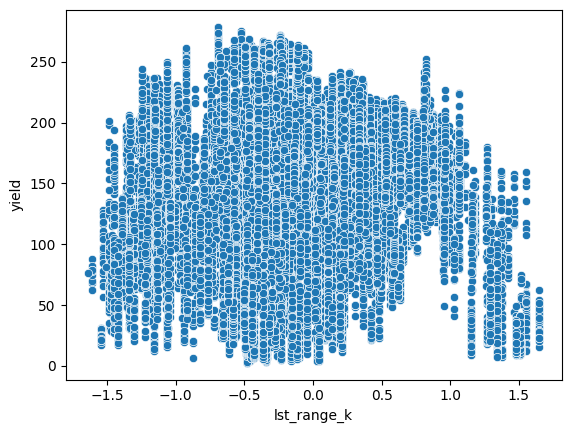

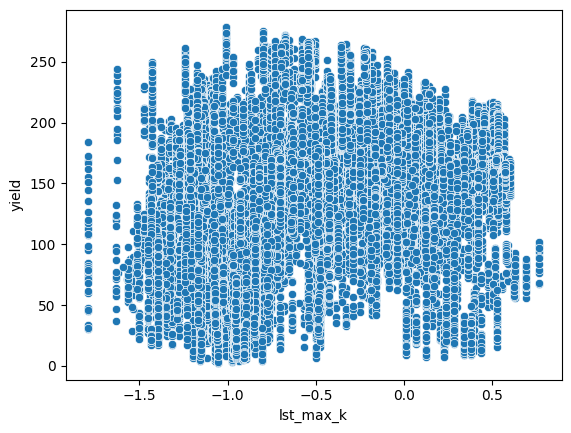

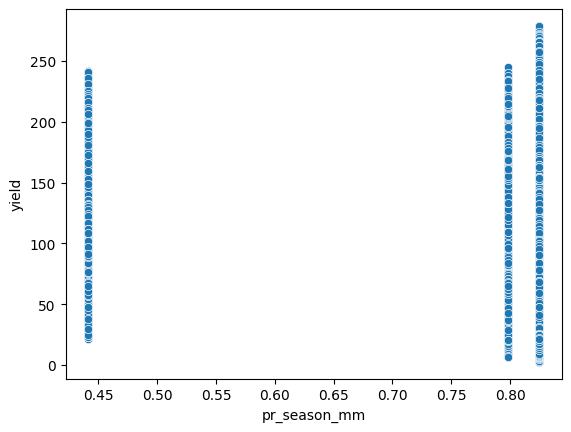

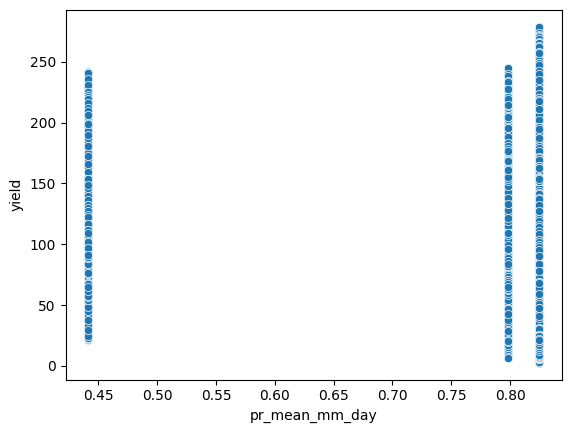

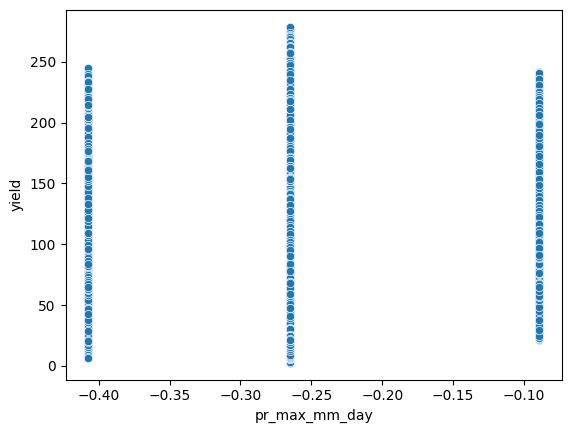

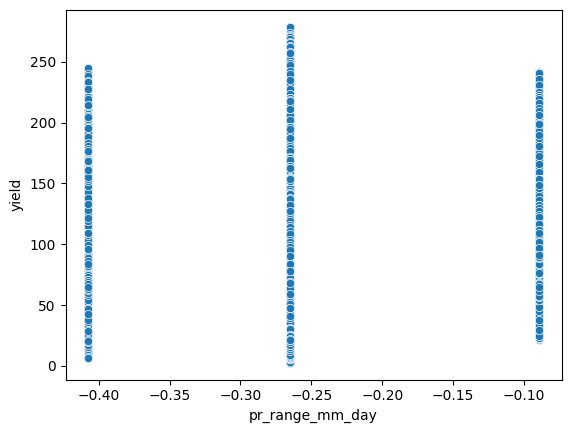

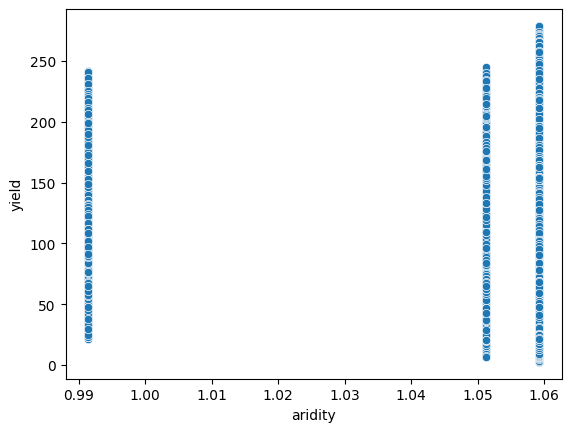

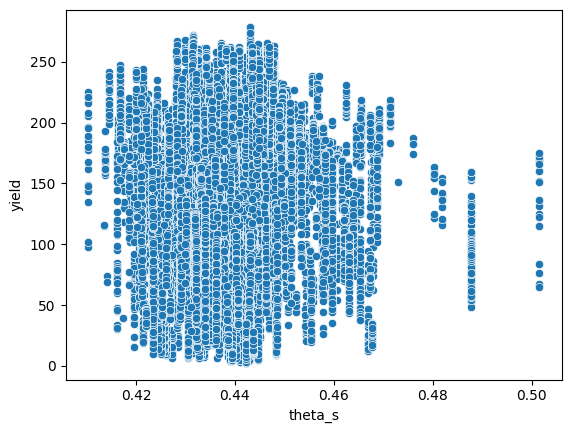

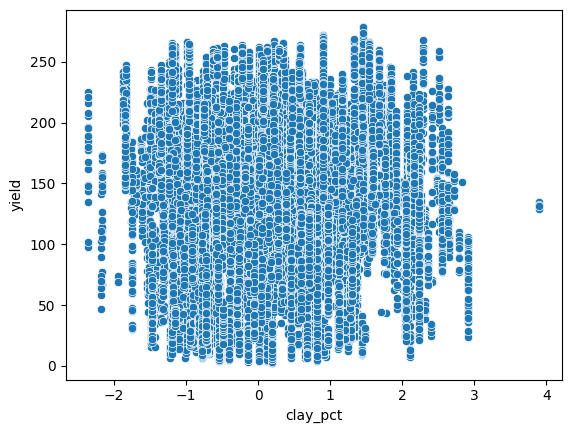

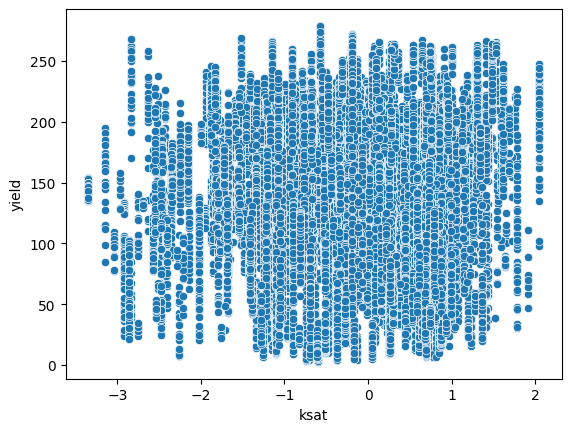

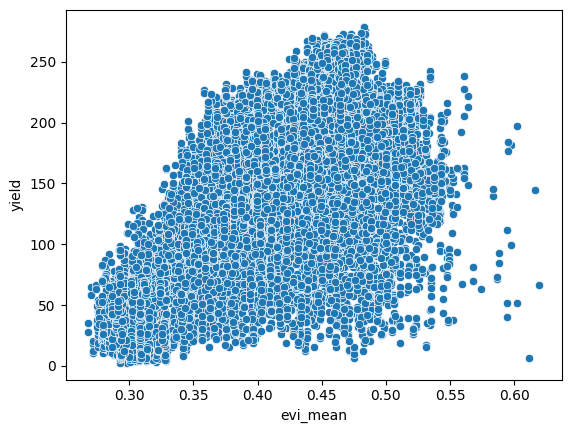

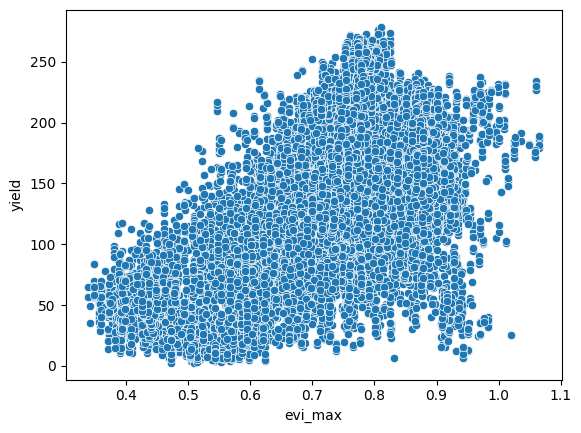

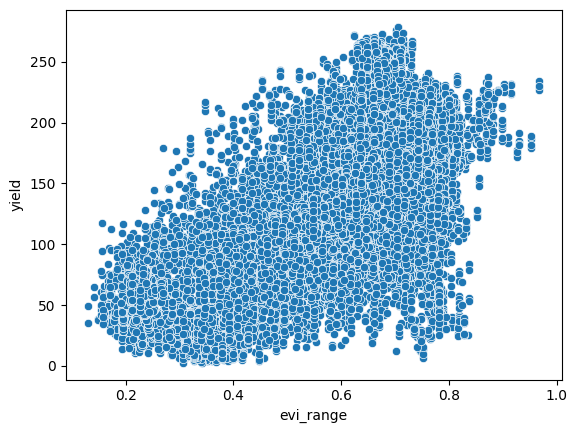

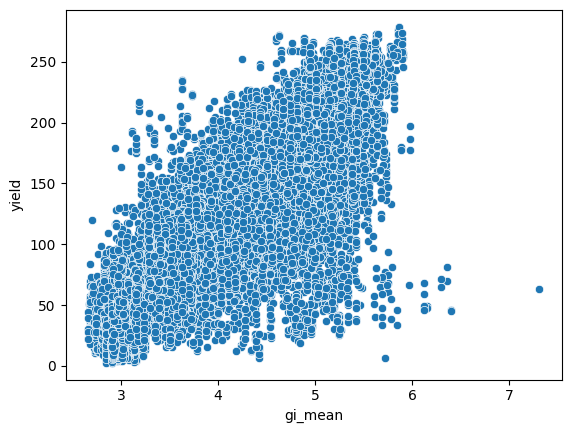

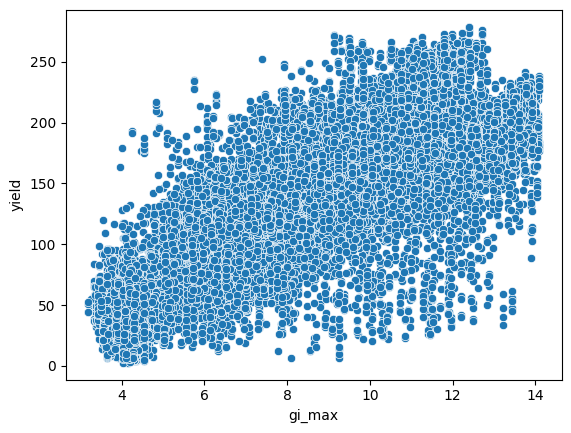

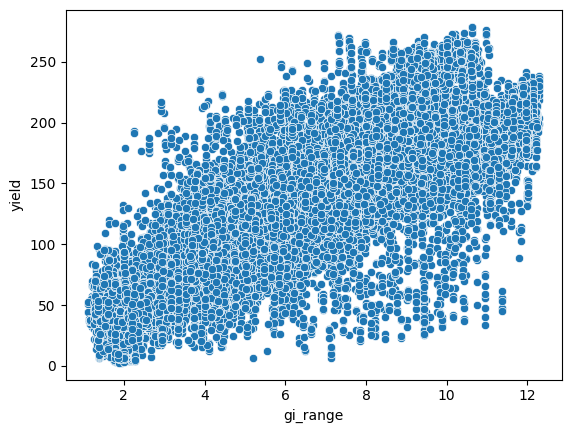

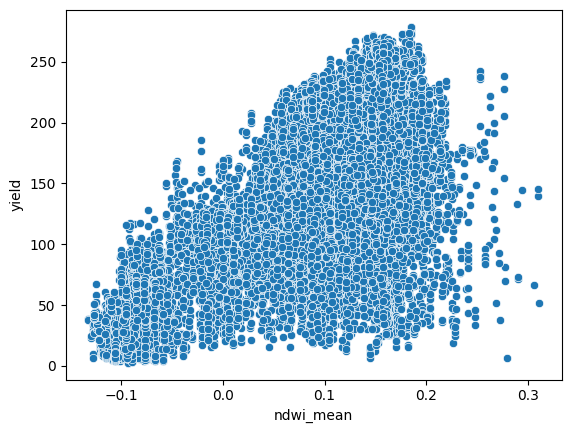

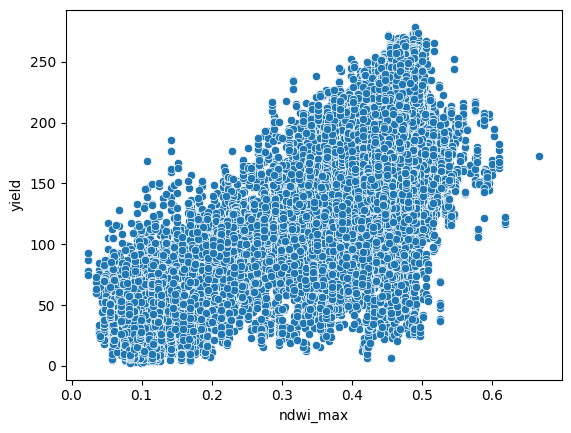

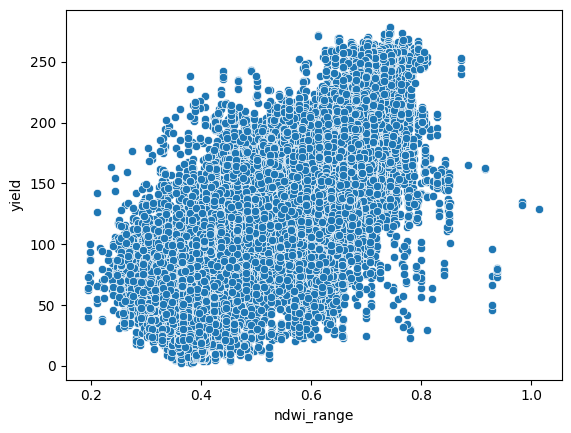

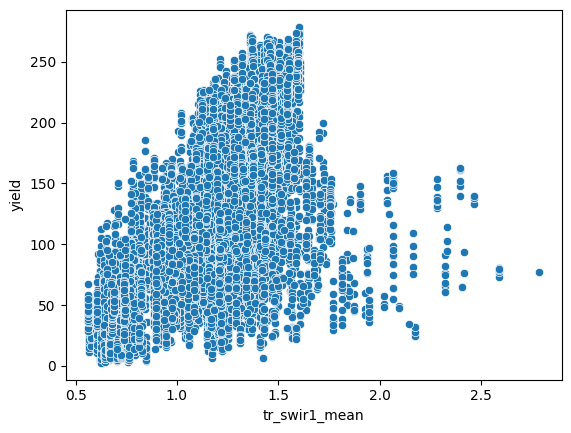

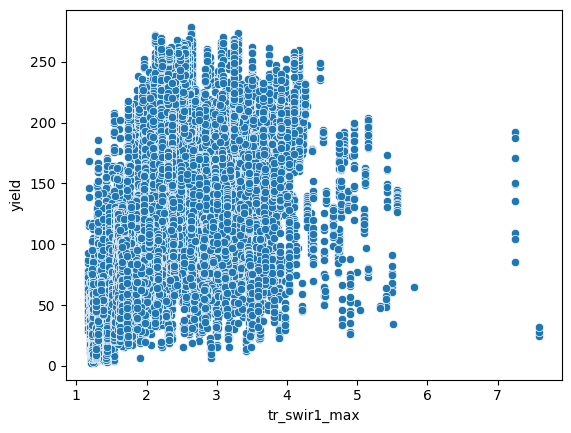

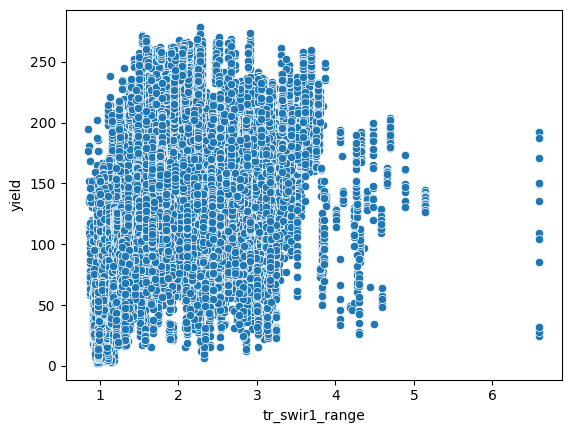

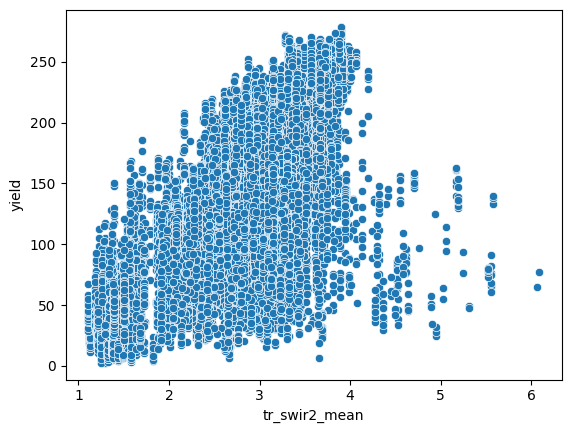

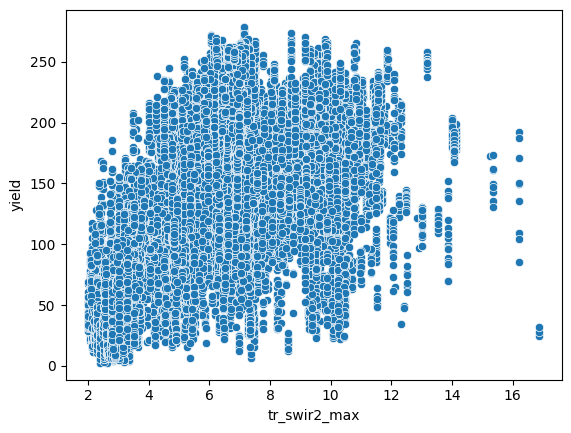

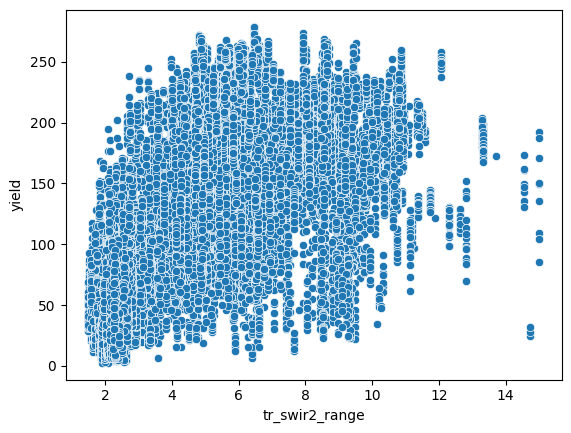

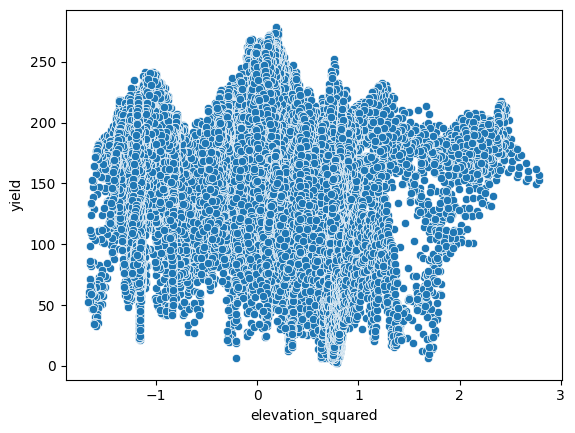

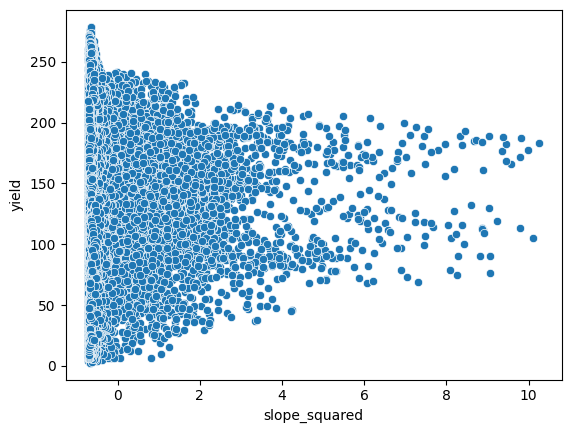

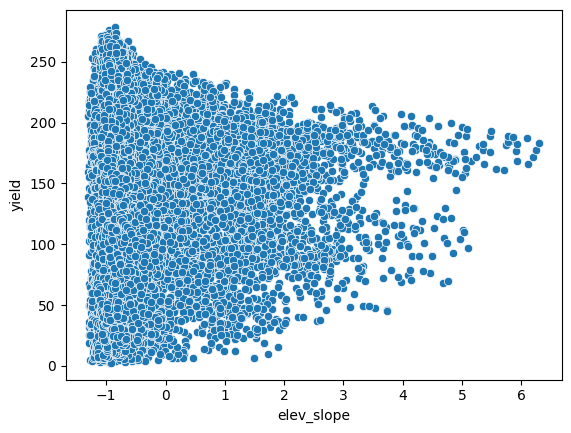

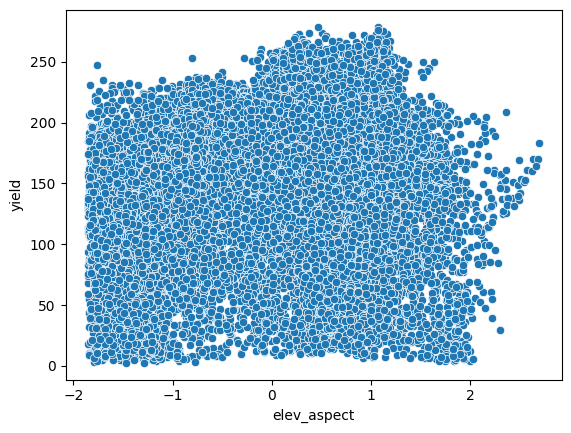

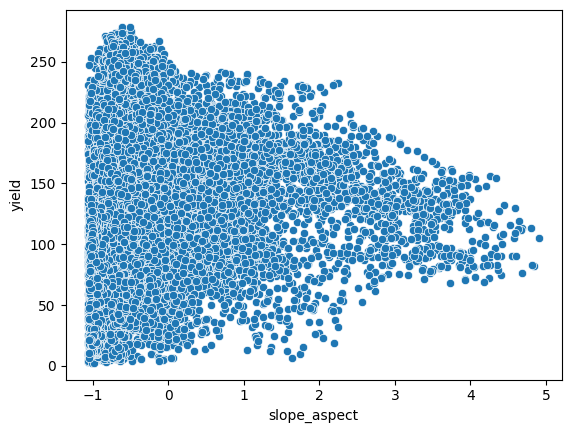

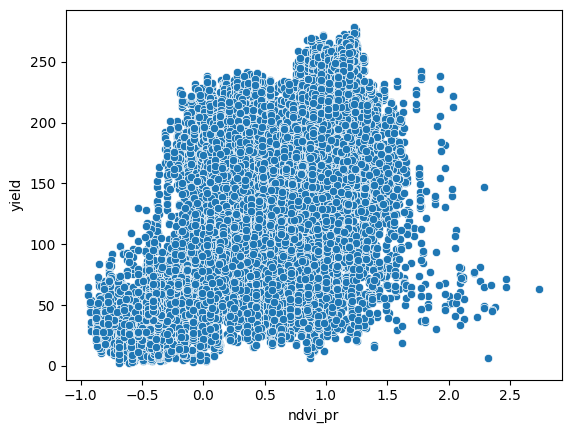

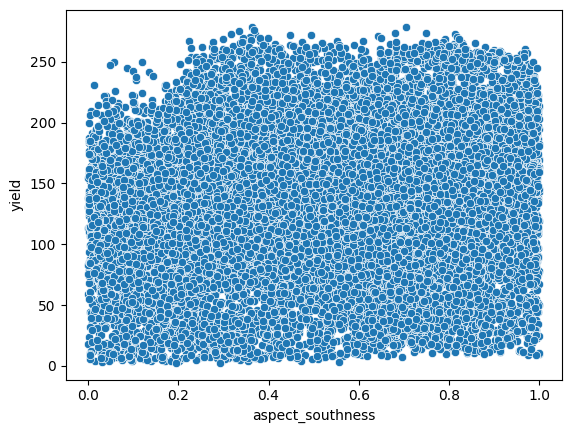

In [ ]:
df_ = df_corn_scaled[df_corn_scaled['year'] == 2022]

for interested_col in [ 'elevation', 'slope', 'aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
       'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
       'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
       'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
       'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect',
       'slope_aspect', 'ndvi_pr', 'aspect_southness']:
       sns.scatterplot(data=df_, x=interested_col, y='yield')
       plt.show()

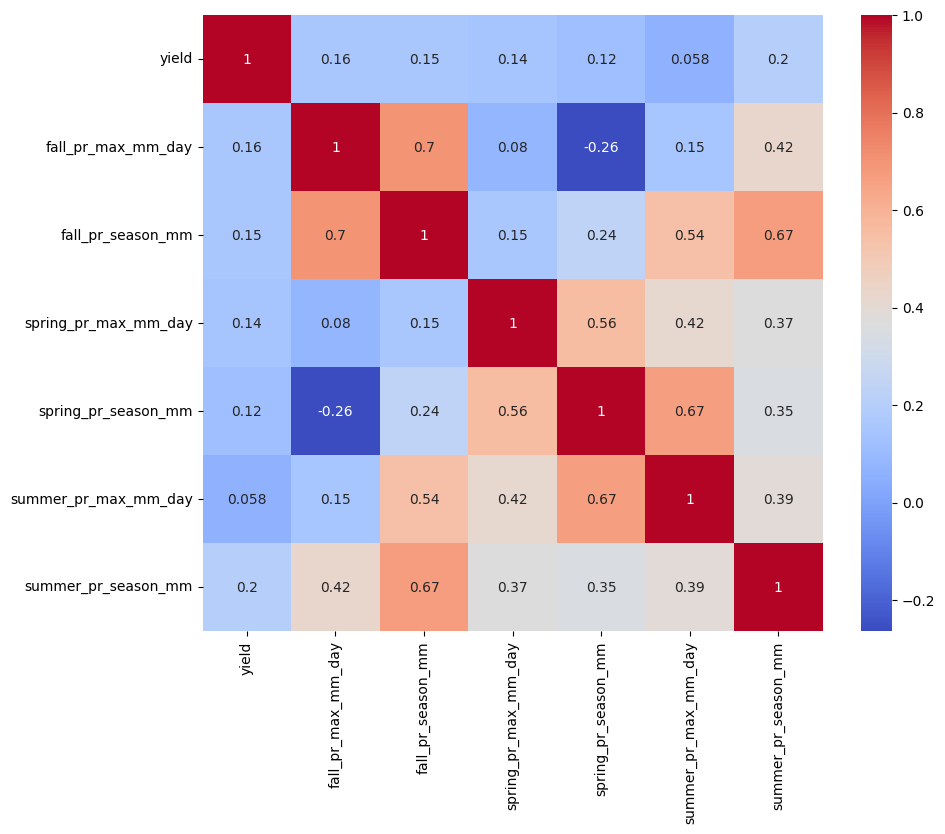

In [78]:
precip_cols = [
   'fall_pr_max_mm_day','fall_pr_season_mm',
    'spring_pr_max_mm_day','spring_pr_season_mm',
    'summer_pr_max_mm_day','summer_pr_season_mm',
]

plt.figure(figsize=(10, 8))
sns.heatmap(df_soybeans_scaled[['yield'] + precip_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [75]:
import pandas as pd
import numpy as np

precip_cols = [
    'fall_aridity','fall_pr_max_mm_day','fall_pr_range_mm_day','fall_pr_season_mm',
    # 'winter_aridity','winter_pr_max_mm_day','winter_pr_range_mm_day','winter_pr_season_mm',
    'spring_aridity','spring_pr_max_mm_day','spring_pr_range_mm_day','spring_pr_season_mm',
    'summer_aridity','summer_pr_max_mm_day','summer_pr_range_mm_day','summer_pr_season_mm',
]

df = df_soybeans_scaled.copy()  # or your df
X = df[precip_cols].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df['yield'], errors='coerce')

# quick peek: correlation matrix to spot redundancy
corrM = X.corr().abs()
# optional: drop one from any pair with |corr|>0.9
to_drop = set()
thr = 0.90  # choose your threshold

# 1) absolute correlation matrix
corrM = X.corr(method="pearson").abs()

# 2) keep only the upper triangle (no self- or duplicate pairs)
mask_upper = np.triu(np.ones_like(corrM, dtype=bool), k=1)
high_pairs = (
    corrM.where(mask_upper)
         .stack()                                # to long form
         .reset_index()
         .rename(columns={"level_0":"feature_1", "level_1":"feature_2", 0:"abs_corr"})
         .query("abs_corr >= @thr")
         .sort_values("abs_corr", ascending=False)
         .reset_index(drop=True)
)

print("Highly correlated pairs (|r| >= {:.2f}):".format(thr))
print(high_pairs.to_string(index=False))

Highly correlated pairs (|r| >= 0.90):
           feature_1              feature_2  abs_corr
  fall_pr_max_mm_day   fall_pr_range_mm_day  1.000000
spring_pr_max_mm_day spring_pr_range_mm_day  1.000000
summer_pr_max_mm_day summer_pr_range_mm_day  1.000000
      summer_aridity    summer_pr_season_mm  0.993486
        fall_aridity      fall_pr_season_mm  0.991991
      spring_aridity    spring_pr_season_mm  0.963174
